# Process an Image for line drawing

In [5]:
from math import sqrt

# import a bunch of stuff that we'll use to manipulate our images...
from skimage.io import imread
#from skimage import filter
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.measure import block_reduce
import numpy as np
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian, roberts, sobel
from skimage.segmentation import active_contour
from skimage.transform import rescale

import scipy
from sklearn.cluster import KMeans
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt

In [6]:
def get_line(start, end):
    """Bresenham's Line Algorithm
    from: http://www.roguebasin.com/index.php?title=Bresenham%27s_Line_Algorithm
    Produces a list of tuples from start and end
 
    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

In [50]:
shelton = imread('img/test_portrait2.jpg')
#shelton = rescale(shelton, 0.25)

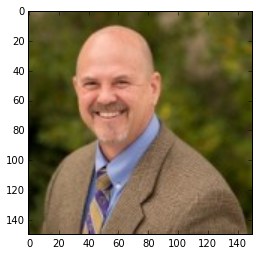

In [51]:
plt.imshow(shelton)

In [52]:
shelton_gray = rgb2gray(shelton)

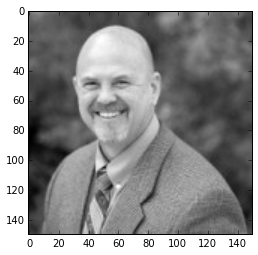

In [53]:
plt.imshow(shelton_gray, cmap=plt.get_cmap('gray'))

In [54]:
shelton_edges = roberts(shelton_gray)

In [55]:
shelton_edges_rev = 1-shelton_edges

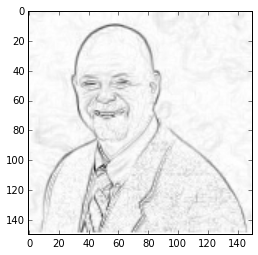

In [56]:
plt.imshow(shelton_edges_rev, cmap=plt.get_cmap('gray'))

In [57]:
noise = np.random.random(shelton_edges_rev.shape)
shelton_edges_noisy = shelton_edges_rev - (noise*0.1)
shelton_edges_points = np.zeros(shelton_edges_noisy.shape)
shelton_edges_points[shelton_edges_noisy<0.8] = 1

In [58]:
shelton_edges_points

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [59]:
shelton_edges_noisy
print len(np.transpose(np.nonzero(shelton_edges_points)))
print np.transpose(np.nonzero(shelton_edges_points))
shelton_points = np.transpose(np.nonzero(shelton_edges_points))


897
[[  9  54]
 [  9  55]
 [  9  56]
 ..., 
 [148  43]
 [148  44]
 [148  69]]


In [60]:
shelton_points

array([[  9,  54],
       [  9,  55],
       [  9,  56],
       ..., 
       [148,  43],
       [148,  44],
       [148,  69]])

## Use Travelling Salesman Algorithm to trace line through all points

In [61]:
# Calculate the euclidian distance in n-space of the route r traversing cities c, ending at the path start.
path_distance = lambda r,c: np.sum([np.linalg.norm(c[r[p]]-c[r[p-1]]) for p in range(len(r))])
# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i],r[k:-len(r)+i-1:-1],r[k+1:len(r)]))

def two_opt(cities,improvement_threshold): # 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt
    route = np.arange(cities.shape[0]) # Make an array of row numbers corresponding to cities.
    improvement_factor = 1 # Initialize the improvement factor.
    best_distance = path_distance(route,cities) # Calculate the distance of the initial path.
    while improvement_factor > improvement_threshold: # If the route is still improving, keep going!
        distance_to_beat = best_distance # Record the distance at the beginning of the loop.
        for swap_first in range(1,len(route)-2): # From each city except the first and last,
            for swap_last in range(swap_first+1,len(route)): # to each of the cities following,
                new_route = two_opt_swap(route,swap_first,swap_last) # try reversing the order of these cities
                new_distance = path_distance(new_route,cities) # and check the total distance with this modification.
                if new_distance < best_distance: # If the path distance is an improvement,
                    route = new_route # make this the accepted best route
                    best_distance = new_distance # and update the distance corresponding to this route.
        improvement_factor = 1 - best_distance/distance_to_beat # Calculate how much the route has improved.
    return route # When the route is no longer improving substantially, stop searching and return the route.


In [62]:
# Create a matrix of cities, with each row being a location in 2-space (function works in n-dimensions).
#cities = np.random.RandomState(42).rand(70,2)
# Find a good route with 2-opt ("route" gives the order in which to travel to each city by row number.)
#route = two_opt(cities,0.001)

In [68]:
route = two_opt(shelton_points, 0.05)

KeyboardInterrupt: 

In [64]:
route

array([  0,   9,   8,   7,  22,   6,  21,  20,  19,  30,  29,  37,  28,
        27,  36,  35,  43,  42,  49,  41,  48,  47,  55,  54,  59,  53,
        58,  63,  62,  66,  65,  71,  70,  74,  78,  77,  81,  85,  84,
        89,  88,  92,  91,  95,  99,  98, 102, 106, 105, 108, 110, 112,
       114, 117, 116, 119, 120, 122, 121, 124, 125, 126, 128, 133, 136,
       147, 148, 149, 137,  10,  11, 138, 139, 140, 141, 134, 142, 143,
       127, 129, 144, 145, 146, 135, 132, 131, 130, 123, 118, 115, 113,
       111, 109, 107, 104, 103, 101, 100,  97,  96,  94,  93,  90,  87,
        86,  83,  82,  80,  79,  76,  75,  73,  72,  69,  68,  67,  64,
        61,  60,  57,  56,  52,  51,  50,  46,  45,  44,  40,  39,  38,
        34,  33,  32,  31,  26,  25,  24,  23,  18,  17,  16,  15,  14,
         5,   4,  13,  12,   3,   2,   1])

In [65]:
shelton_points[route]

array([[ 9, 54],
       [10, 54],
       [10, 53],
       [10, 52],
       [11, 52],
       [10, 51],
       [11, 51],
       [11, 50],
       [11, 49],
       [12, 49],
       [12, 48],
       [13, 47],
       [12, 47],
       [12, 46],
       [13, 46],
       [13, 45],
       [14, 45],
       [14, 44],
       [15, 44],
       [14, 43],
       [15, 43],
       [15, 42],
       [16, 42],
       [16, 41],
       [17, 41],
       [16, 40],
       [17, 40],
       [18, 40],
       [18, 39],
       [19, 39],
       [19, 38],
       [20, 38],
       [20, 37],
       [21, 37],
       [22, 37],
       [22, 36],
       [23, 36],
       [24, 36],
       [24, 35],
       [25, 35],
       [25, 34],
       [26, 35],
       [26, 34],
       [27, 34],
       [28, 34],
       [28, 33],
       [29, 33],
       [30, 33],
       [30, 32],
       [31, 32],
       [32, 32],
       [33, 32],
       [34, 32],
       [35, 32],
       [35, 31],
       [36, 31],
       [36, 32],
       [37, 32],
       [37, 31

In [66]:
x, y = zip(*(shelton_points[route]))

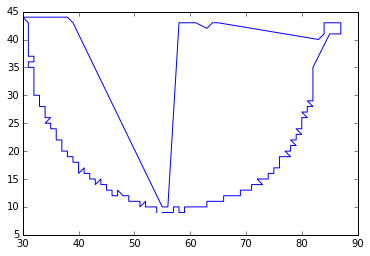

In [67]:
plt.plot(y, x)

In [47]:
plot_points = shelton_points[route]

In [48]:
def cable_steps(x, y, d=500, steps_per_inch=5):
    a = int((sqrt(x**2 + y**2))*steps_per_inch)
    b = int((sqrt((d-x)**2 + y**2))*steps_per_inch)
    return a, b

In [ ]:
for 